<a href="https://colab.research.google.com/github/solong96/solong96/blob/main/spatial_category_mac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import time
import csv
from tqdm import tqdm
import collections
import sys
import os
import openpyxl
import re
import pandas as pd
import numpy as np
import json
import warnings
import sklearn
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets				# 내장 데이터 사용
from sklearn.model_selection import train_test_split	# train, test 데이터 분할
from keras.utils import to_categorical

from sklearn.linear_model import LinearRegression	# 선형 회귀분석
from sklearn.linear_model import LogisticRegression	# 로지스틱 회귀분석
from sklearn.naive_bayes import GaussianNB		# 나이브 베이즈
from sklearn import svm					# 서포트 벡터 머신
from sklearn import tree				# 의사결정나무
from sklearn.ensemble import RandomForestClassifier	# 랜덤포레스트

from sklearn.datasets import make_classification
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


In [71]:
import warnings

# 경고메세지 끄기
# warnings.filterwarnings(action='ignore')

# # 다시 출력하게 하기
warnings.filterwarnings(action='default')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# content = pd.read_excel('F:/02. 유영은(박사과정)/OneDrive - 충북대학교/05. 수업/08. AI 교육/ICT/spatial_category/gir_landuse_binary.xlsx')
content = pd.read_excel('/content/drive/MyDrive/gir_landuse_binary.xlsx')
content

,ID,년도,시군구,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,...,폐기물,순배출량,총배출량,주거,상업,공업,녹지,도농,type,class
0,1,2020,강원_강릉시,2083865,435547,3400,367,89803,300260,425348,...,154098,5996492,6629677,0.023249,0.002449,0.007608,0.072632,0.894062,도농,4
1,2,2020,강원_고성군,43710,55157,0,0,0,38674,90022,...,16174,-140118,324258,0.008965,0.001150,0.000600,0.024243,0.965042,도농,4
2,3,2020,강원_동해시,2890367,176244,6166,0,531,123163,151010,...,61268,8370666,8482792,0.087770,0.014250,0.059450,0.543740,0.294790,녹지,3
3,4,2020,강원_삼척시,5022982,124887,230,0,561,125620,185856,...,49728,8619953,9305902,0.009543,0.000952,0.007405,0.053718,0.928382,도농,4
4,5,2020,강원_속초시,27626,148327,0,0,7,121526,178000,...,62167,462186,552797,0.169990,0.062598,0.029240,0.738172,0.000000,녹지,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,1370,2015,충북_제천시,1604959,288644,0,142,7226,242281,283115,...,81561,4111594,4465011,0.011409,0.002047,0.005732,0.079758,0.901054,도농,4
1370,1371,2015,충북_증평군,222774,73815,0,0,1430,48022,60644,...,17083,407914,462626,0.061151,0.005401,0.035780,0.193115,0.704553,도농,4
1371,1372,2015,충북_진천군,951474,150897,0,570,360,89454,152872,...,95416,1584276,1801926,0.021845,0.002120,0.015374,0.051388,0.909272,도농,4
1372,1373,2015,충북_청주시,3963163,1652455,0,39662,22307,1329257,1433665,...,939416,9769034,10278839,0.060109,0.006961,0.026848,0.417691,0.488391,도농,4


In [51]:
contents = content.copy()
contents = contents.loc[:,content.columns[3:14]]
contents['class'] = content['class']
contents

,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,산업공정,AFOLU(농업),AFOLU(LULUCF),폐기물,class
0,2083865,435547,3400,367,89803,300260,425348,3020664,116325,-633185,154098,4
1,43710,55157,0,0,0,38674,90022,2,80519,-464376,16174,4
2,2890367,176244,6166,0,531,123163,151010,5061718,12325,-112126,61268,3
3,5022982,124887,230,0,561,125620,185856,3741502,54536,-685949,49728,4
4,27626,148327,0,0,7,121526,178000,3,15141,-90611,62167,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1369,1604959,288644,0,142,7226,242281,283115,1860947,96136,-353417,81561,4
1370,222774,73815,0,0,1430,48022,60644,3,38855,-54712,17083,4
1371,951474,150897,0,570,360,89454,152872,142885,217998,-217650,95416,4
1372,3963163,1652455,0,39662,22307,1329257,1433665,463526,435388,-509805,939416,4


In [52]:
contents.describe()

,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,산업공정,AFOLU(농업),AFOLU(LULUCF),폐기물,class
count,1.374000e+03,1.374000e+03,1374.000000,1374.000000,1374.000000,1.374000e+03,1.374000e+03,1.374000e+03,1.374000e+03,1.374000e+03,1374.000000,1374.000000
mean,1.188011e+06,4.220010e+05,5627.460699,6949.374818,11088.168122,3.629430e+05,4.031544e+05,6.584289e+05,1.464909e+05,-1.785708e+05,107342.320233,3.194323
std,2.952011e+06,4.086516e+05,28527.847050,56846.351983,33122.199804,4.428986e+05,4.005208e+05,2.220975e+06,1.724204e+05,2.360006e+05,113743.873747,1.250525
min,4.389000e+03,2.407300e+04,0.000000,0.000000,0.000000,6.697000e+03,2.009700e+04,-2.424500e+04,1.000000e+00,-1.444504e+06,2777.000000,0.000000
25%,7.464500e+04,1.238640e+05,0.000000,0.000000,364.250000,8.316225e+04,1.208552e+05,4.000000e+00,5.039750e+03,-2.638898e+05,28470.750000,3.000000
50%,2.435580e+05,2.959000e+05,0.000000,0.000000,2051.500000,2.227105e+05,2.718240e+05,1.500000e+01,8.522250e+04,-9.681250e+04,71080.000000,4.000000
75%,1.005020e+06,5.645220e+05,58.500000,0.000000,6438.750000,4.848740e+05,5.512238e+05,2.144575e+04,2.288172e+05,-9.050250e+03,150045.000000,4.000000
max,2.453508e+07,2.416124e+06,387840.000000,671068.000000,396516.000000,3.103402e+06,2.421722e+06,1.749153e+07,1.296835e+06,3.526690e+05,959086.000000,4.000000


In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

contents[contents.columns[0:11]] = scaler.fit_transform(contents[contents.columns[0:11]])
contents.head()

,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,산업공정,AFOLU(농업),AFOLU(LULUCF),폐기물,class
0,0.084770,0.172017,0.008767,0.000547,0.226480,0.094799,0.168740,0.173838,0.089698,0.451442,0.158234,4
1,0.001603,0.012995,0.000000,0.000000,0.000000,0.010326,0.029116,0.001384,0.062088,0.545372,0.014009,4
2,0.117648,0.063615,0.015898,0.000000,0.001339,0.037610,0.054510,0.290365,0.009503,0.741374,0.061163,3
3,0.204584,0.042145,0.000593,0.000000,0.001415,0.038403,0.069020,0.214992,0.042052,0.422082,0.049096,4
4,0.000947,0.051945,0.000000,0.000000,0.000018,0.037081,0.065748,0.001384,0.011675,0.753346,0.062103,3


In [58]:
data = datasets.load_iris()

data['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [67]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [69]:
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

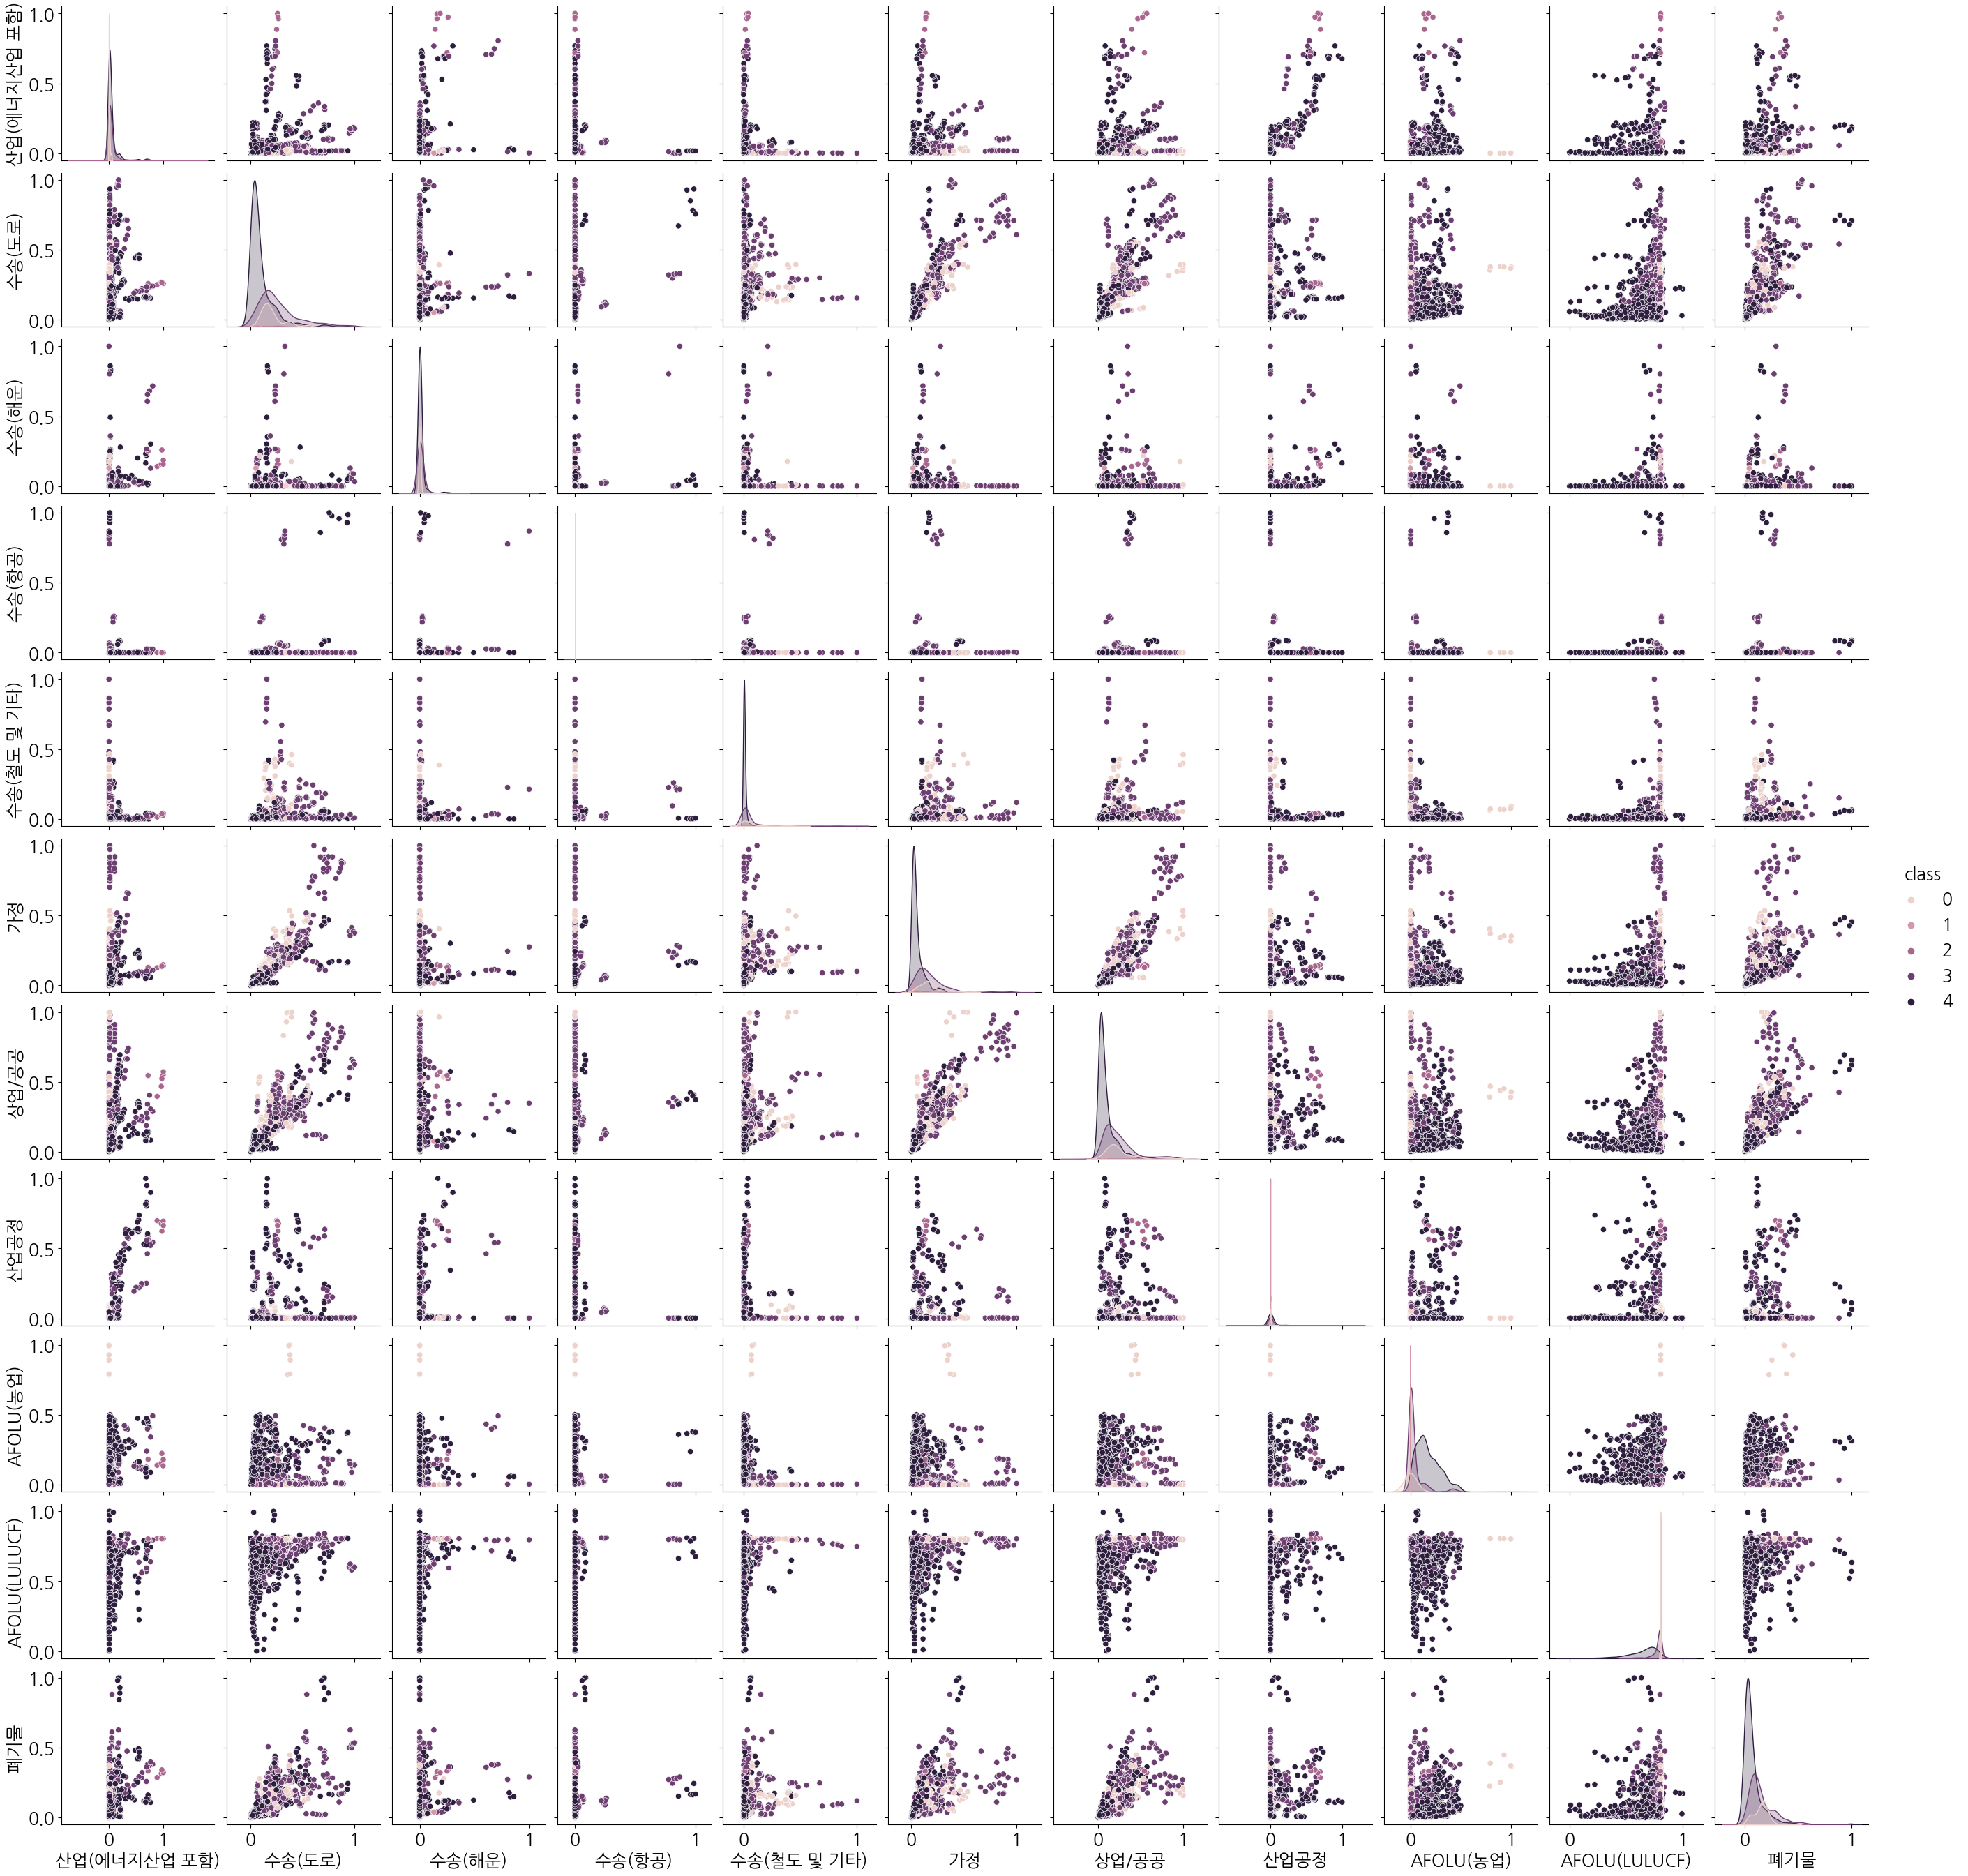

In [72]:
import seaborn as sns

sns.pairplot(contents, hue='class', vars = contents.columns[0:11])
plt.show()

In [73]:
contents['class'].unique()

array([4, 3, 0, 1, 2])

In [74]:
x_data = pd.DataFrame(contents[contents.columns[0:11]])
y_data = contents.loc[:,'class']

print(x_data[0:5])
print(y_data[0:5])

   산업(에너지산업 포함)    수송(도로)    수송(해운)    수송(항공)  수송(철도 및 기타)        가정  \
0      0.084770  0.172017  0.008767  0.000547     0.226480  0.094799   
1      0.001603  0.012995  0.000000  0.000000     0.000000  0.010326   
2      0.117648  0.063615  0.015898  0.000000     0.001339  0.037610   
3      0.204584  0.042145  0.000593  0.000000     0.001415  0.038403   
4      0.000947  0.051945  0.000000  0.000000     0.000018  0.037081   

      상업/공공      산업공정  AFOLU(농업)  AFOLU(LULUCF)       폐기물  
0  0.168740  0.173838   0.089698       0.451442  0.158234  
1  0.029116  0.001384   0.062088       0.545372  0.014009  
2  0.054510  0.290365   0.009503       0.741374  0.061163  
3  0.069020  0.214992   0.042052       0.422082  0.049096  
4  0.065748  0.001384   0.011675       0.753346  0.062103  
0    4
1    4
2    3
3    4
4    3
Name: class, dtype: int64


In [75]:
#전체 중 20%를 테스트용으로 분할,나머지 80%는 훈련용
(x_train, x_valid, y_train, y_valid) = train_test_split(x_data, y_data, train_size=0.8, random_state=1)

#원-핫 인코딩(one-hot encoding)
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

#5개씩만 출력
print(y_train[:5])
print(y_valid[:5])

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [39]:
# 학습을 위한 라이브러리 임포트
from sklearn.linear_model import LogisticRegression #Logistic(Regression)Classifier
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.svm import SVC #Support Vector Machine
from sklearn.naive_bayes import GaussianNB #Naive Bayesian
from sklearn.neighbors import KNeighborsClassifier #K Nearest Neighbor
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.ensemble import GradientBoostingClassifier #Gradient Boosing
from sklearn.neural_network import MLPClassifier #Neural Network

from sklearn.metrics import accuracy_score

from sklearn import model_selection

In [40]:
models = []
models.append(("LR", LogisticRegression()))
models.append(("DT", DecisionTreeClassifier()))
models.append(("SVM", SVC()))
models.append(("NB", GaussianNB()))
models.append(("KNN", KNeighborsClassifier()))
models.append(("RF", RandomForestClassifier()))
models.append(("GB", GradientBoostingClassifier()))
models.append(("ANN", MLPClassifier()))

In [41]:
# 교차 검증
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=True)
    cv_results = model_selection.cross_val_score(model, x_data, y_data.values.ravel(), cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

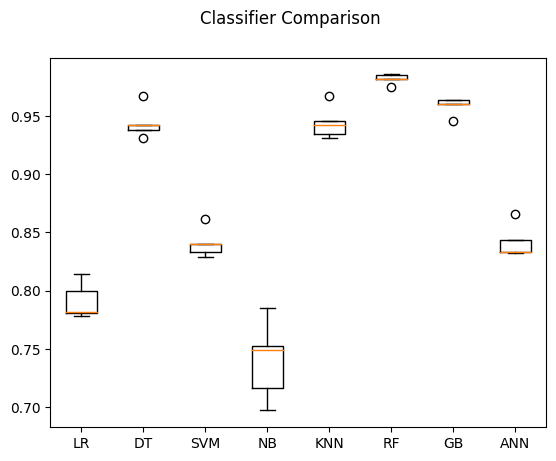

In [42]:
fig = plt.figure()

fig.suptitle('Classifier Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

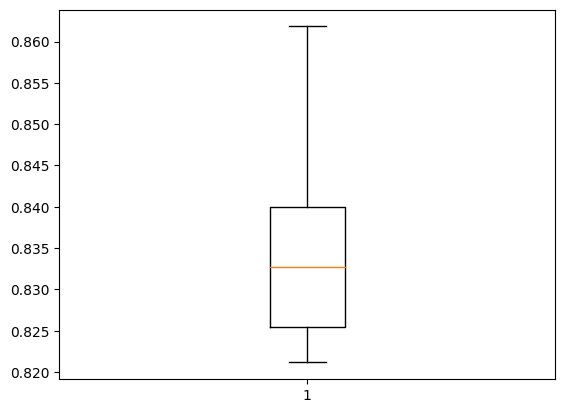

In [43]:
model = LogisticRegression()
parameters = {
    'C' : [2**0, 2**3, 2**6, 2**9, 2**12],
    'random_state' : [0, 7, 13, 42]
}
gs = model_selection.GridSearchCV(model, parameters)
gs.fit(x_data, y_data.values.ravel())
model = gs.best_estimator_

kfold = model_selection.KFold(n_splits=5, random_state=7, shuffle=True)
cv_results = model_selection.cross_val_score(model, x_data, y_data.values.ravel(), cv=kfold, scoring="accuracy")
plt.boxplot(cv_results)
plt.show()

In [79]:
(x_train, x_valid, y_train, y_valid) = train_test_split(x_data, y_data, train_size=0.8, random_state=1)

lr = LogisticRegression(max_iter = 1000)
lr.fit(x_train,y_train)

pred = lr.predict(x_valid[:5])
print(pred)

[3 4 3 4 4]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
print(lr.score(x_train, y_train))
print(lr.score(x_valid, y_valid))

0.7934485896269335
0.8327272727272728


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
lr.coef_

# https://itstory1592.tistory.com/11 해석참조

array([[-2.2982573 , -0.82628361, -0.90715022, -1.01390491,  1.03190591,
         1.69836724,  1.92232998, -1.17458705, -1.78792372,  3.42011053,
         0.96739033],
       [-0.17534634, -0.41544624,  0.29035272, -0.03975669, -0.13299494,
        -0.40262423, -0.3382605 , -0.13998934, -0.34745053,  0.27315015,
        -0.34187747],
       [ 2.48790305, -0.41292978,  0.23031215, -0.07861348, -0.1506648 ,
        -0.38753745,  0.48619035,  1.18055456, -0.28768543,  0.55519012,
         0.20450655],
       [ 0.76842607,  2.09737067,  0.56946564,  0.03262931,  0.58728209,
         1.66948821,  0.34066948, -0.94047949, -3.1891217 ,  1.86425123,
        -0.12875664],
       [-0.78272549, -0.44271103, -0.18298028,  1.09964578, -1.33552826,
        -2.57769376, -2.4109293 ,  1.07450133,  5.61218139, -6.11270203,
        -0.70126278]])

In [82]:
lr.intercept_

array([-2.0417144 , -2.27747425, -2.40887982, -0.04422725,  6.77229572])

In [90]:
X = pd.DataFrame(lr.coef_)
X.columns = contents.columns[0:11]
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,산업공정,AFOLU(농업),AFOLU(LULUCF),폐기물
0,-2.298257,-0.826284,-0.907150,-1.013905,1.031906,1.698367,1.922330,-1.174587,-1.787924,3.420111,0.967390
1,-0.175346,-0.415446,0.290353,-0.039757,-0.132995,-0.402624,-0.338261,-0.139989,-0.347451,0.273150,-0.341877
2,2.487903,-0.412930,0.230312,-0.078613,-0.150665,-0.387537,0.486190,1.180555,-0.287685,0.555190,0.204507
3,0.768426,2.097371,0.569466,0.032629,0.587282,1.669488,0.340669,-0.940479,-3.189122,1.864251,-0.128757
4,-0.782725,-0.442711,-0.182980,1.099646,-1.335528,-2.577694,-2.410929,1.074501,5.612181,-6.112702,-0.701263


In [94]:
X.to_excel('/content/drive/MyDrive/logistic_결과.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [91]:
X['절편'] = pd.DataFrame(lr.intercept_)
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,산업공정,AFOLU(농업),AFOLU(LULUCF),폐기물,절편
0,-2.298257,-0.826284,-0.907150,-1.013905,1.031906,1.698367,1.922330,-1.174587,-1.787924,3.420111,0.967390,-2.041714
1,-0.175346,-0.415446,0.290353,-0.039757,-0.132995,-0.402624,-0.338261,-0.139989,-0.347451,0.273150,-0.341877,-2.277474
2,2.487903,-0.412930,0.230312,-0.078613,-0.150665,-0.387537,0.486190,1.180555,-0.287685,0.555190,0.204507,-2.408880
3,0.768426,2.097371,0.569466,0.032629,0.587282,1.669488,0.340669,-0.940479,-3.189122,1.864251,-0.128757,-0.044227
4,-0.782725,-0.442711,-0.182980,1.099646,-1.335528,-2.577694,-2.410929,1.074501,5.612181,-6.112702,-0.701263,6.772296


In [87]:
decision = lr.decision_function(x_train[:5])
print(np.round(decision, decimals=2))

[[-0.87 -2.35 -2.19  0.35  5.07]
 [ 0.47 -2.11 -2.    1.23  2.42]
 [ 1.15 -2.28 -2.01  2.08  1.07]
 [-0.31 -2.47 -2.09  0.22  4.65]
 [ 0.9  -2.13 -1.95  1.58  1.6 ]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [88]:
from scipy.special import softmax

proba = softmax(decision, axis=1)
print(np.round(proba, decimals = 3))

[[0.003 0.001 0.001 0.009 0.987]
 [0.097 0.007 0.008 0.206 0.681]
 [0.221 0.007 0.009 0.559 0.204]
 [0.007 0.001 0.001 0.012 0.979]
 [0.196 0.01  0.011 0.387 0.397]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
